<a href="https://colab.research.google.com/github/johnreyes96/artificial-vision/blob/master/src/main/python/QualityMeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import pandas as pd
import os
from distutils.dir_util import copy_tree
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import numpy as np 

In [3]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/vision_artificial/images/meats'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
base_dir = "/content/drive/MyDrive/vision_artificial/images/meats"

"""Define paths."""
base_kaggle_path = "/content/drive/MyDrive/vision_artificial/images/meats/outputs"
paths = ["train","val"]
"""Create new subdirectories with class names for train and val."""
classes = ["FRESH","SPOILED"]
for i in range(len(paths)):
    for j in range(len(classes)):
        sub_folder = os.path.join(paths[i],classes[j])
        os.makedirs(os.path.join(base_kaggle_path,sub_folder))


os.listdir(base_kaggle_path+"/train")

train_path = os.path.join(base_dir,"train")
"""For train."""
for filename in os.listdir(train_path):
    if filename.rfind("FRESH") == 0:
        copy_tree(os.path.join(train_path,filename),base_kaggle_path + "/train/FRESH")
    elif filename.rfind("SPOILED") == 0:
        copy_tree(os.path.join(train_path,filename),base_kaggle_path + "/train/SPOILED")
    else:
        pass

val_path = os.path.join(base_dir,"valid")
"""For validation."""
for filename in os.listdir(val_path):
    if filename.rfind("FRESH") == 0:
        copy_tree(os.path.join(val_path,filename),base_kaggle_path + "/val/FRESH")
    elif filename.rfind("SPOILED") == 0:
        copy_tree(os.path.join(val_path,filename),base_kaggle_path + "/val/SPOILED")
    else:
        pass

print("Training : \n")
print(len(os.listdir(base_kaggle_path+"/train/FRESH")))
print(len(os.listdir(base_kaggle_path+"/train/SPOILED")))
print("Validation : \n")
print(len(os.listdir(base_kaggle_path+"/val/FRESH")))
print(len(os.listdir(base_kaggle_path+"/val/SPOILED")))

/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-1.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-2.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-3.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-4.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-5.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-6.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-7.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-9.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-10.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/FRESH/FRESH-8.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/SPOILED/SPOILED-1.jpg
/content/drive/MyDrive/vision_artificial/images/meats/train/SPOILED/SPOILED-2.jpg
/content/drive/MyDrive/vision_artificial/images/meats/t

# Xpredition method



In [4]:
# PRE PROCESSING OF IMAGES
"""All images will be scaled to 1./255 to obtain 0-1 normalized image.Also image augmentation is used."""
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,rotation_range = 40,
                                                                 width_shift_range = 0.2,height_shift_range = 0.2,
                                                                 shear_range = 0.2,zoom_range = 0.2,
                                                                 horizontal_flip = True,vertical_flip = True,
                                                                 fill_mode = "nearest",)
"""Validation images also will be scale dto 1./255 to obtain 0-1 normalized image,but image augmentation is NOT USED."""
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(os.path.join(base_kaggle_path,"train"),target_size = (300,300),
                                                   class_mode = "categorical",batch_size = 32,seed = 42)
validation_generator = validation_datagen.flow_from_directory(os.path.join(base_kaggle_path,"val"),target_size = (300,300),
                                                    class_mode = "categorical",batch_size = 32,seed = 42,shuffle = False)

# TRANSFER LEARNING MODEL
# (1)Use Xception as base model.

base_model = Xception(input_shape = (300,300,3),weights = "imagenet",include_top = False,pooling = "max")
"""Freeze layers to stop updating weights of base model."""
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 

In [5]:
# (2)Create an architecture to feed models.
"""Here,we can assign last layer as add_11.It means that we can start to update weights after this layer"""
last_layer = base_model.get_layer("add_11")
print(last_layer.output_shape)

"""GlobalAveragePooling layer to reduce input dim to 1D."""
x = tf.keras.layers.BatchNormalization()(last_layer.output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
"""Fully connected layer."""
x = tf.keras.layers.Dense(128,activation = "relu")(x)
"""Add dropout layer."""
x = tf.keras.layers.Dropout(0.3)(x)
"""Output layer"""
x = tf.keras.layers.Dense(2,activation = "softmax")(x)
"""Here,we can connect model end to end."""
model = tf.keras.models.Model(base_model.input,x)

print(model.summary())


# COMPILE AND FIT
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate =0.0001),loss = "categorical_crossentropy",metrics = ["acc"])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if epoch >= 10 and logs.get("acc") - logs.get("val_acc") >= 0.1:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
        elif logs.get("acc") > 0.9:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
callback = myCallback()

history = model.fit(train_generator,epochs = 20,batch_size = 32,validation_data = validation_generator,
                   callbacks = [callback,],verbose = 1)

(None, 10, 10, 1024)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                        

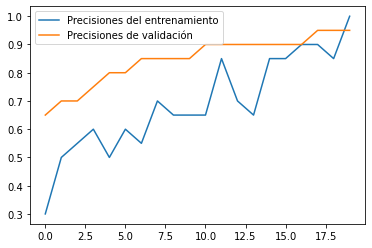

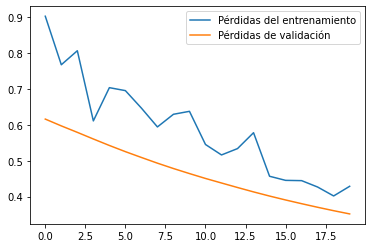

1/1 [==============================] - 1s 1s/step
La predicción es : SPOILED


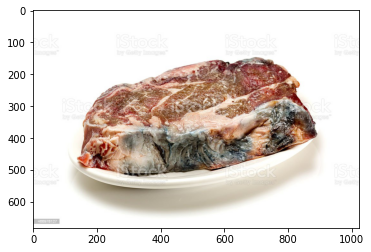

In [7]:
# PLOT RESULTS
"""Precisiones."""
acc = history.history["acc"]
val_acc = history.history["val_acc"]
epochs = range(20)
plt.plot(epochs,acc,label = "Precisiones del entrenamiento")
plt.plot(epochs,val_acc,label = "Precisiones de validación")
plt.legend()
plt.show()

"""Pérdidas."""
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs,loss,label = "Pérdidas del entrenamiento")
plt.plot(epochs,val_loss,label = "Pérdidas de validación")
plt.legend()
plt.show()

# Guarda el modelo y lo carga
model.save("meat_classify.h5")
model1 = tf.keras.models.load_model("meat_classify.h5")

# Obtiene la imagen de internet y la procesa
def get_and_process(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img1 = img
    """Resize img to proper for feed model."""
    img = img.resize((300,300))
    """Convert img to numpy array,rescale it,expand dims and check vertically."""
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x / 255.0 
    x = np.expand_dims(x,axis = 0)
    img_tensor = np.vstack([x])
    return img1,img_tensor


# FINAL : Predecir imagen
url = "https://media.istockphoto.com/photos/spoiled-steak-picture-id466978127"
img1,test_img = get_and_process(url)

pred = model1.predict(test_img)
classes = list(train_generator.class_indices.keys())
print(f"La predicción es : {classes[np.argmax(pred)]}")
plt.imshow(img1)
plt.show()

print(classes)
print(pred)